In [1]:
import os
import sys
import time

import numpy as np
import scipy as sci
from scipy.integrate import solve_ivp
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, Circle
from matplotlib import animation
import warnings

%matplotlib widget

warnings.filterwarnings("ignore")

from IPython.display import HTML

from pandas.plotting import scatter_matrix
from pandas.plotting import autocorrelation_plot

from scipy.signal import hilbert 
from scipy.optimize import fsolve
from scipy.optimize import root

In [2]:
cwd = os.getcwd()
cwd

'd:\\My Stuff\\AMU!\\PhD\\CODE\\Simulation\\Python\\Notebooks\\Doubles_Pong'

In [3]:
def genAngle(ball_init, ball_End, ball_height):
    
    xDiff = np.abs(ball_init - ball_End)
    hypotenuse = np.sqrt(np.power(xDiff,2) + np.power(ball_height,2))
    alpha = np.arcsin((xDiff/hypotenuse))
    
    return alpha

In [4]:
def calculateBounds(xInit, xEnd, v_y, ballHeight):
    
    deltaT = (0 - ballHeight)/v_y
    v_x = (xEnd - xInit)/deltaT
    
    return v_x, deltaT

In [5]:
def ballKinematics(t, x0, y0, v0_x, v0_y, a0_x, a0_y):
    
    x = v_x * t
    y = v_y * t
    
    return x, y

In [6]:
def doublesPongSystem(t, y, a, b, x0, alpha, beta, v_x):
    
    x1 = y[0]
    x2 = y[1]
    
    x0_t = v_x * t + x0
    
    
    g12 = (x1 - x2)*(alpha + beta * np.power((x1 - x2), 2))
    g21 = (x2 - x1)*(alpha + beta * np.power((x2 - x1), 2))
    
    dx1 = -a * (x1 - x0_t) + b*g12
    dx2 = -a * (x2 - x0_t) + b*g21
    
    return [dx1, dx2]

In [16]:
def plotPongSystem(t, x1, x2, ballPos, ballRanges, ballHeight):
    
    fig, axe = plt.subplots()
    
    axe.plot(t, x1, c = 'blue', label = r'$X_1$')
    axe.plot(t, x2, c = 'red', label = r'$X_2$')
    axe.plot(t,ballPos[0,:], c = 'k', ls = '--', label = r'$X_0$')
    
    axe.set_xlim([0, max(t)])
    axe.set_ylim(ballRanges)
    axe.set_xlabel('Time')
    axe.set_ylabel('Paddle position')
    axe.set_title('Simulation trajectory')
    
    lgd = axe.legend(frameon = False)

    return fig, axe

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Simulation trajectory'}, xlabel='Time', ylabel='Paddle position'>)

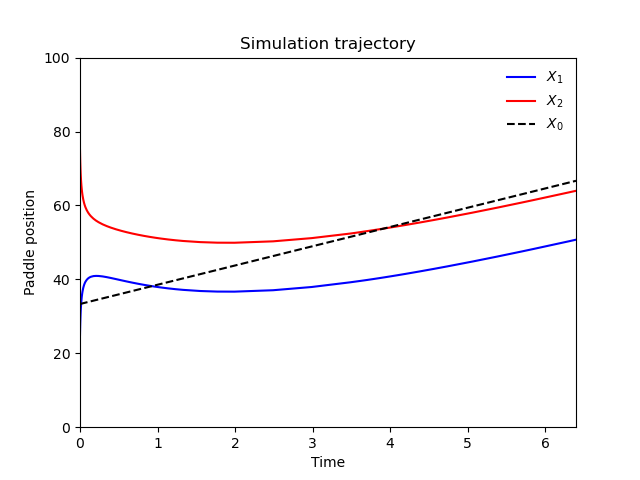

In [17]:
plotPongSystem(t, x1, x2, ballPos, ballRanges, ballHeight)

In [37]:
class animatePongSystem:
        
    def __init__(self, x1, x2, ballPos, ballRanges, ballHeight):

        self.fig, self.axe = plt.subplots(1,1)
        
        self.ballRanges = ballRanges
        self.ballHeight = ballHeight
        # self.tsz = tsz
        
        self.x1 = x1
        self.x2 = x2
        self.ballPos = ballPos
        
        tsz = 15
        
        self.axe.set_xlim([ballRanges[0]-1, ballRanges[1]+1])
        self.axe.set_ylim([-2, round(ballHeight+10,-1)])
        self.axe.set_xlabel('Interception axis', size = tsz)
        self.axe.set_ylabel('Height', size = tsz)
        self.axe.tick_params(labelsize = tsz-2, length = 0)
        self.axe.set_xticks(np.linspace(ballRanges[0], ballRanges[-1], 7))
        self.axe.set_yticks(np.linspace(0, ballHeight, 5))
        self.axe.axhline(64, ls = '--', color = 'darkgray')
        
        plt.tight_layout()
        
        self.paddle1 = self.axe.add_patch(Rectangle((100, 100), 3, 1,
                 edgecolor = 'blue',
                 facecolor = 'blue',
                 fill=True,
                 lw=5))
        
        self.paddle2 = self.axe.add_patch(Rectangle((100, 100), 3,1,
             edgecolor = 'red',
             facecolor = 'red',
             fill=True,
             lw=5))
        
        self.ball = self.axe.add_patch(Circle((100, 100), radius = 0.5,
                 edgecolor = 'k',
                 facecolor = 'k',
                 fill=True,
                 lw=5))
    
    
    def setInitPos(self):
        
        self.paddle1.set_xy((100, 100))
        self.paddle2.set_xy((100, 100))
        self.ball.set_center([100,100])
        
        return self.paddle1, self.paddle2, self.ball,
    
    
    def update(self, frame):
        
        self.paddle1.set_xy((self.x1[frame], 0))
        self.paddle2.set_xy((self.x2[frame], 0))
        self.ball.set_center([self.ballPos[0, frame], self.ballPos[1, frame]])
        return self.paddle1, self.paddle2, self.ball,



In [39]:
def saveAnim(anim, name): 
    writergif = animation.PillowWriter(fps=30) 
    anim.save(name, writer=writergif)

In [21]:
ballRanges = [-52.5, 52.5]
# ballRanges = [0, 100]

ballHeight = 64
ball_init = np.linspace(ballRanges[0], ballRanges[1], 7)
xVec = ball_init


paddlePos = [-30.25, 30.25]
# paddlePos = [np.diff(ballRanges)[0]//4, np.diff(ballRanges)[0]//4*3]

bStart = ball_init[2]
bEnd = xVec[4]
alpha = genAngle(bStart, bEnd, ballHeight)
beta = np.pi/2 - alpha
# alpha = np.rad2deg(alpha)
# beta = 90 - alpha
alpha = 2
a = 0.5
beta = -0.01

b = 1
v_y = -10
v_x, tend = calculateBounds(bStart, bEnd, v_y, ballHeight)

In [52]:
sol = solve_ivp(doublesPongSystem, (0, tend+0), paddlePos,
                args = (a, b, bStart, alpha, beta, v_x), method = 'RK45', dense_output=True)
t = sol.t
x1 = sol.y[0]
x2 = sol.y[1]
ballPosX = v_x * t + bStart
ballPosY = v_y * t + ballHeight

ballPos = np.array([ballPosX, ballPosY])

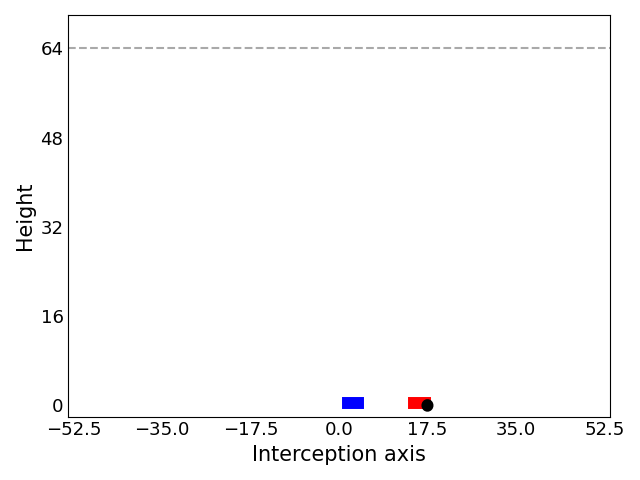

In [57]:
aps = animatePongSystem(x1, x2, ballPos, ballRanges, ballHeight)

anim = animation.FuncAnimation(aps.fig, aps.update, init_func=aps.setInitPos, save_count = len(t),
                               interval = 1000, repeat = True, blit=True)
saveAnim(anim, "testanim.gif")

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Simulation trajectory'}, xlabel='Time', ylabel='Paddle position'>)

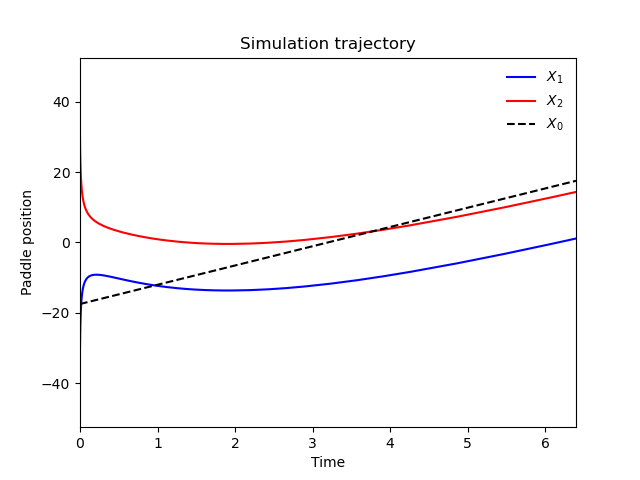

In [25]:
aa = x2 - x1

# fig, ax = plt.subplots()
# ax.plot(t,aa)
plotPongSystem(t, x1, x2, ballPos, ballRanges, ballHeight)
# plt.plot(t,aa)

# Equations

We define the doubles-system as a system of two-coupled reduced van der pol - Rayleigh Oscillator. This implementation shares many features with the Excitator model (Jirsa & Kelso, 2008).

The movement equations of the two participants are denoted by the variables $x_1$ & $x_2$:

$\dot x_1 = -a(x_1 - x_0) + K_{12}$

$\dot x_2 = -a(x_2 - x_0) + K_{21}$

Where $K_{12}$ & $K_{21}$ denote the coupling between the two participants:

$ K_{12} = (x_1 - x_2)(\alpha + \beta(x_1 - x_2)^2)$

$ K_{21} = (x_2 - x_1)(\alpha + \beta(x_2 - x_1)^2)$

Taking the difference of the two ODEs:

$\dot x_2 - \dot x_1 = -a(x_2 - x_1)+ 2(x_2 - x_1)(\alpha + \beta (x_2 - x_1)^2)$

Defining $x$ as $x_2 - x_1$, we get the $\Delta$ equation:

$\dot x = (2\alpha - a)x + 2 \beta x^2$

With the solution:

$ x = \frac{(2\alpha -a)^2 e^{a c_1 + 2at}}{2 \beta e^{a c_1 + 2at} + e^{at + 2 a c_1}}$

Checking some of the qualitative states based on $\Delta$ Eq.:
* $a < 2\alpha \quad$ \& $\quad \beta < 0:\quad$ Partial convergence (in-phase synchronization)
* $a > 2\alpha \quad$ \& $\quad \beta < 0:\quad$ Full convergence
* $a = 2\alpha \rightarrow x = 0:\quad$ Static difference between the trajectories
* $\beta > 0:\quad$ Divergence (Explosive movement towards $-\infty\quad \& \quad\infty$)



# Cases

In order to visually assess the validity of the aforementioned states, we will run simulations based on various values of $(\alpha $, $a$, $ \beta)$:

## Divergence

In [ ]:
alpha = 2
aVec = {'divergence': 0.5, 'static': 2*alpha, 'convergence': [0.5, 2*alpha+1]}
beta = {'divergence': 0.01, 'convergence': -0.01}

params = ((2, 0.5, 0.01),
          (2, 2*alpha, 0.01),
          (2, 0.5, -0.01),
          (2, 0.5, -0.01))

b = 1
v_y = -10

results = []

for i in range(4):

    v_x, tend = calculateBounds(bStart, bEnd, v_y, ballHeight)
    sol = solve_ivp(doublesPongSystem, (0, tend+0), paddlePos,
                    args = (a, b, bStart, alpha, beta, v_x), method = 'LSODA')
    t = sol.t
    x1 = sol.y[0]
    x2 = sol.y[1]
    ballPosX = v_x * t + bStart
    ballPosY = v_y * t + ballHeight
    ballPos = np.array([ballPosX, ballPosY])

    results.append([t, x1, x2, ballPos])

In [ ]:

aps = animatePongSystem(x1, x2, ballPos, ballRanges, ballHeight)

anim = animation.FuncAnimation(aps.fig, aps.update, init_func=aps.setInitPos,
                               interval = 20, repeat = False, blit=True)

In [30]:
def plotstuff():
    aps = animatePongSystem(x1, x2, ballPos, ballRanges, ballHeight)

    anim = animation.FuncAnimation(aps.fig, aps.update, init_func=aps.setInitPos,
                                interval = 20, repeat = False, blit=True)
    _,_ = plotPongSystem(t, x1, x2, ballPos, ballRanges, ballHeight)

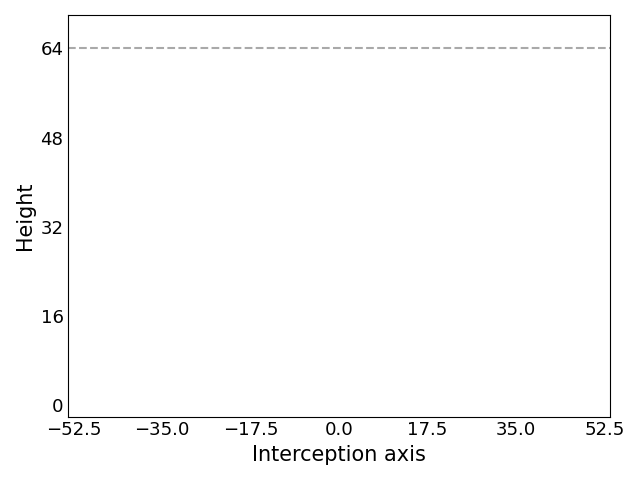

In [35]:
aps = animatePongSystem(x1, x2, ballPos, ballRanges, ballHeight)

anim = animation.FuncAnimation(aps.fig, aps.update, init_func=aps.setInitPos,
                            interval = 20, repeat = False, blit=True)

## Constant (static) difference

## Convergence